# 餐飲業逾期風險預測模型
由我國「應建立食品追溯追蹤系統之食品業者」規定可知，須申報食品流向資料於本署非追不可系統多為製造與輸入業者，對於販售與餐飲業者則無相關資料可用，無法推算其庫存，進而評估其是否可能存放逾期食品。因此，針對販售與餐飲業者，則透過後市場稽查資料及業者相關資訊，嘗試以監督式學習方法建構業者逾期食品違規風險預測模型，而此處為餐飲業資料的建模評估。

### 程式架構
* 資料前處理(Preprocessing.ipynb)
* 特徵篩選(ModelFitting.ipynb)
* **模型配適(FeatureSelection.ipynb)**

## 模型配適

### Package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

### Data Import

In [3]:
dict_dfs_fs = pd.read_pickle('../data/data_fs.pkl')
print(dict_dfs_fs.keys())

dict_keys(['others', 'train', 'test', 'feature_selection'])


In [4]:
# training set
X_train = dict_dfs_fs['train']['X_select']
y_train = dict_dfs_fs['train']['y']

# testing set
X_test = dict_dfs_fs['test']['X_select']
y_test = dict_dfs_fs['test']['y']

### Handling Imbalanced Datasets
以 SMOTENC 進行資...

In [5]:
from imblearn.over_sampling import SMOTENC

In [6]:
# 先將數值資料轉為 float ，合成樣本後再四捨五入，避免向零截斷（truncation toward zero）
cols_num = ['資本額', '餐飲業次業別數', '標章分數', '場所規模']
X_sm0 = pd.concat([X_train[cols_num].astype('float32'), X_train.drop(cols_num, axis=1)], axis=1)

In [9]:
# 類別特徵名稱
cols_cat = list(X_train.drop(labels=cols_num, axis=1).columns)

# 建立 SMOTENC 物件
sm = SMOTENC(
    categorical_features=cols_cat,    # 指定類別特徵
    sampling_strategy=3/7,    # minor/major
    random_state=423
)

# 合成樣本（加在原始資料後）
X_sm, y_sm = sm.fit_resample(X_sm0, y_train)
X_sm = X_sm.round(0)

In [10]:
del X_sm0, cols_cat, sm

In [ ]:
# # 檢測 dummy encoding 特徵
# print(X_sm.columns)

# (X_sm.filter(like='場所型式', axis=1).sum(axis=1) > 1).sum()

Index(['資本額', '餐飲業次業別數', '標章分數', '場所規模', '營業縣市_台中市', '營業縣市_台北市', '營業縣市_台南市',
       '營業縣市_台東縣', '營業縣市_嘉義市', '營業縣市_嘉義縣', '營業縣市_基隆市', '營業縣市_宜蘭縣', '營業縣市_屏東縣',
       '營業縣市_彰化縣', '營業縣市_新北市', '營業縣市_新竹市', '營業縣市_新竹縣', '營業縣市_桃園市', '營業縣市_澎湖縣',
       '營業縣市_花蓮縣', '營業縣市_苗栗縣', '營業縣市_連江縣', '營業縣市_金門縣', '營業縣市_雲林縣', '營業縣市_高雄市',
       '場所型式_b', '場所型式_c', '場所型式_d', '是否兼具製造業', '是否兼具販售業', '上市上櫃', '導入HACCP',
       '導入ISO22000', '來源流向管理', '投保責任險', '倉儲', '食添法規認知', '逾期食品法規認知', '有直營連鎖店',
       '有加盟連鎖店', '同一地址有多個餐飲場所', '有餐飲場所且有工廠製造場所', '有餐飲場所且委託他廠代工', '美食平台',
       '有無專技人員', '有無技術士證照'],
      dtype='object')


np.int64(0)

### Standardization

In [8]:
from sklearn.preprocessing import StandardScaler

In [11]:
ss = StandardScaler().set_output(transform='pandas')

ss.fit(X_train[cols_num])    # 須以原始訓練集特徵做縮放依據

def scalar_df(df, cols, scalar): 
    df_scale = scalar.transform(df[cols])
    df_notScale = df.drop(cols, axis=1)
    df_rsl = pd.concat([df_scale, df_notScale], axis=1)
    return df_rsl

X_sm_ss = scalar_df(df=X_sm, cols=cols_num, scalar=ss)
X_test_ss = scalar_df(df=X_test, cols=cols_num, scalar=ss)

In [12]:
del cols_num, ss, X_sm, X_test

### Shuffle

In [13]:
from sklearn.utils import shuffle

In [14]:
y_sm, X_sm_ss = shuffle(y_sm, X_sm_ss, random_state=426)

### Model Fitting: Logistic Regression (with L1 penalty) 

In [15]:

def fit_lgs_l1(X, y): 
    mdl = LogisticRegression(penalty='l1', solver='liblinear', max_iter=100, random_state=422)
    mdl.fit(X, y)
    return mdl

lgs_sm = fit_lgs_l1(X_sm_ss, y_sm)

### Evaluation

In [16]:
# 採用特徵
X_sm_ss.columns[lgs_sm.coef_.flatten() > 0]

Index(['資本額', '標章分數', '投保責任險', '有無技術士證照'], dtype='object')

In [ ]:
# 預測結果
def result_df(model, X_test, y_test): 
    
    df_rsl = pd.DataFrame(
        {'Actual': y_test.reset_index(drop=True), 
         'PredProb': model.predict_proba(X_test)[:, 1].round(4)}, 
    )

    df_rsl['PredProbRank'] = df_rsl['PredProb'].rank(method='min', ascending=False).astype('uint16')

    return df_rsl

df_rsl = result_df(model=lgs_sm, X_test=X_test_ss, y_test=y_test)


* ROC

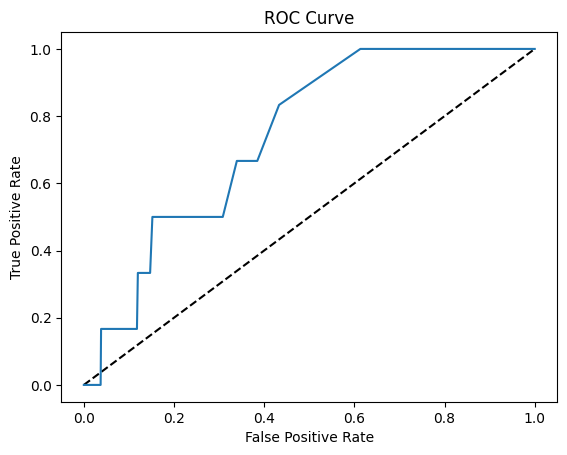

In [24]:
def tprp_rate(actual, pred_prob): 
    
    # true positive rate
    ntp = np.array([((actual == 1) & (pred_prob > thr)).sum() for thr in np.linspace(1, 0, 1001)])
    rtp = ntp / actual.sum()
    
    # false positive rate
    nfp = np.array([((actual == 0) & (pred_prob > thr)).sum() for thr in np.linspace(1, 0, 1001)])
    rfp = nfp / (actual == 0).sum()

    # 補點 (1, 1) ，避免預測機率為 0 情況
    rtp = np.append(rtp, 1.0)
    rfp = np.append(rfp, 1.0)

    return rtp, rfp

rtp_sm, rfp_sm = tprp_rate(actual=df_rsl['Actual'], pred_prob=df_rsl['PredProb'])

plt.plot(np.linspace(0, 1, 3), np.linspace(0, 1, 3), 'k--')
plt.plot(rfp_sm, rtp_sm)

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel("True Positive Rate")
plt.show()

* Confusion Matrix

In [ ]:
# 設定閾值為預測機率排序前 200 名
df_rsl['預測排序'] = df_rsl['預測機率'].rank(method='min', ascending=False).astype('uint16')
df_rsl['預測結果_by排序'] = (df_rsl['預測排序'] <= 200).astype('uint8')    # Pandas Vectorization

In [ ]:
# 建立混淆矩陣
tp = df_rsl[(df_rsl['真實值'] == 1) & (df_rsl['預測結果_by排序'] == 1)].shape[0]
fp = df_rsl[(df_rsl['真實值'] == 0) & (df_rsl['預測結果_by排序'] == 1)].shape[0]
fn = df_rsl[(df_rsl['真實值'] == 1) & (df_rsl['預測結果_by排序'] == 0)].shape[0]
tn = df_rsl[(df_rsl['真實值'] == 0) & (df_rsl['預測結果_by排序'] == 0)].shape[0]

# 橫軸 Actual，縱軸 Predicted，左上 True Positive
nda_cm = np.array([[tp, fp], [fn, tn]])
nda_cm

In [ ]:
# Evaluation Metrics
precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1 = 2 / ((1/precision) + (1/recall))

print(f'precision: {precision: .4f} \nrecall: {recall: .4f} \nf1-score: {f1: .4f}')

In [ ]:
# 繪製混淆矩陣
cm_labels = np.array(['違規', '非違規'])
disp = ConfusionMatrixDisplay(nda_cm, display_labels=cm_labels)

# 設定中文字型（整體）
plt.rcParams['font.family'] = 'Microsoft JhengHei'

# 設定顏色
disp.plot(cmap='Blues')

# 設定軸標題
plt.xlabel("Actual", fontsize=12)
plt.ylabel("Predicted", fontsize=12)

# 設定標題
score_string = f'Precision: {precision: .4f} | Recall: {recall: .4f} | F1-score: {f1: .4f}'
plt.title('Confusion Matrix\n' + score_string)

plt.show()

In [ ]:
# 違規案件預測結果排序
df_rsl = pd.DataFrame(
    {'真實值': y_test, 
     '預測機率': lgs.predict_proba(X_test_ss)[:, 1].round(4), 
     '預測機率(SMOTE)': lgs_sm.predict_proba(X_test_ss)[:, 1].round(4)}
)

i = 0
for id, real, prob1, prob2 in df_rsl.sort_values(by='預測機率', ascending=False).itertuples(): 
    i += 1
    if real: 
        print(f'第{id}筆資料為{real}，預測機率為{prob1}，預測機率(SMOTE)為{prob2}，排序在第{i}位')
